In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# sense of derivative
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1 = ', d1)
print('d2 = ', d2)
print('slope = ', (d2 - d1)/h)

d1 =  4.0
d2 =  3.9999699999999994
slope =  -3.000000000064062


_______________________

In [87]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out =  Value((self.data * other.data), (self, other), '*')
    
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # utilizing topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    

In [78]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label='e'
d = e + c
d.label='d'
f = Value(-2.0, label='f')
l = d*f
l.label = 'l'
l

Value(data=-8.0)

In [79]:
# run once per run
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

In [80]:
# visualizing the origin of a Value
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
        
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name=uid+n._op , label=n._op)
            dot.edge(uid+n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

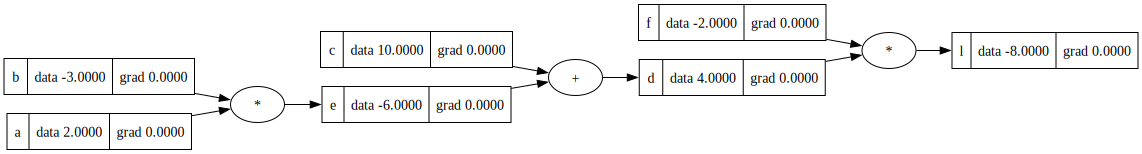

In [81]:
draw_dot(l)

___________________________________________

In [114]:
# One simple neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(2.0, label='x2')

# weights w1,w2
w1 = Value(-0.3, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(-1, label='b')

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

n=x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

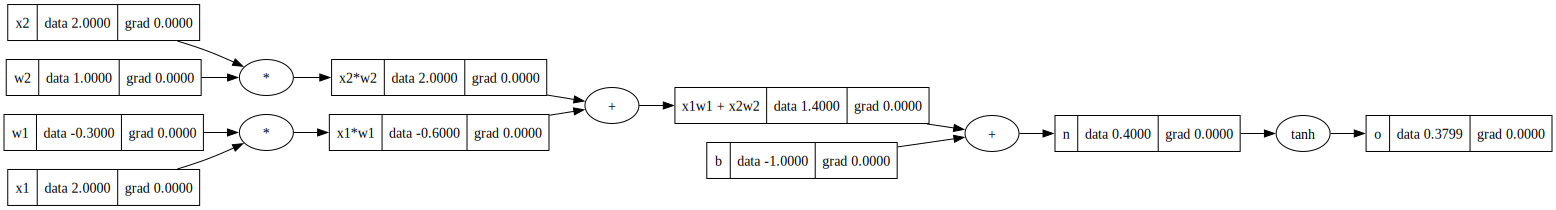

In [104]:
draw_dot(o)

In [100]:
# Manual Backpropagation

In [54]:
# do/dn = 1-tanh(n)**2
# do/dn = 1-o**2
n.grad = 0.5

In [55]:
# below based on chain rule

In [56]:
# '+' is just a distributor of gradient
b.grad = 0.5
x1w1x2w2.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

In [40]:
# '*' multipolies with counterpart 
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

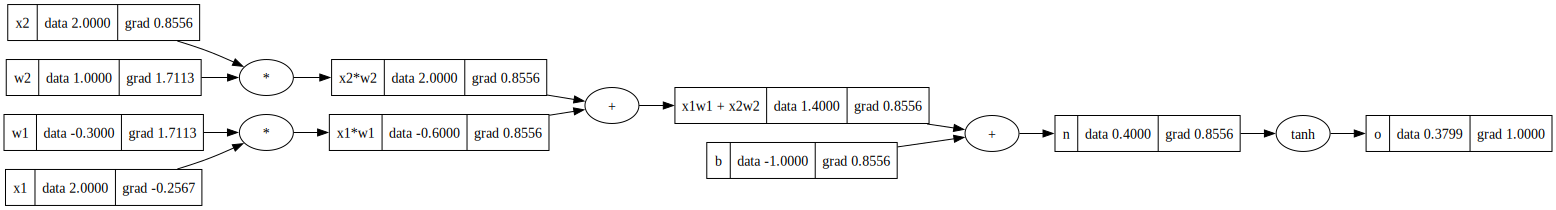

In [112]:
# after doing manual backpropagation
draw_dot(o)

In [105]:
# Automated Backpropagation

In [ ]:
o.grad = 1.0

In [106]:
o._backward()

In [107]:
n._backward()

In [108]:
b._backward()

In [109]:
x1w1x2w2._backward()

In [110]:
x1w1._backward()
x2w2._backward()

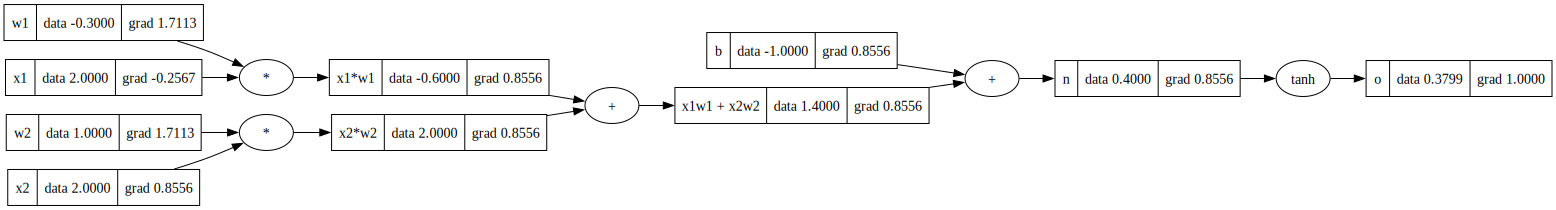

In [119]:
draw_dot(o)

____________________________________